In [ ]:
import pandas as pd
import numpy as np
import json
import gzip
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.svm import SVC
import copy
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from keras.callbacks import EarlyStopping, Callback, ReduceLROnPlateau
from keras.metrics import AUC


# 1. Create DataFrame

In [3]:
def json_gz_to_dataframe(gz_file_path):
    data = []
    
    with gzip.open(gz_file_path, 'rt') as file:
        for line in file:
            try:
                json_data = json.loads(line)
                
                for transcript_id, positions in json_data.items():
                    for position, sequences in positions.items():
                        for sequence, reads in sequences.items():
                            fivemer_neg_1 = sequence[:5]  # First 5 nucleotides (e.g., "AAGAC")
                            fivemer_0 = sequence[1:6]     # Middle 5 nucleotides (e.g., "AGACC")
                            fivemer_1 = sequence[2:]      # Last 5 nucleotides (e.g., "GACCA")
                            
                            for read in reads:
                                row = [
                                    transcript_id,                # transcript_id
                                    int(position)-1,              # position_neg_1
                                    read[0], read[1], read[2],    # dwelling_time_neg_1, sd_neg_1, mean_neg_1
                                    int(position),                # position_0
                                    read[3], read[4], read[5],    # dwelling_time_0, sd_0, mean_0
                                    int(position)+1,              # position_1
                                    read[6], read[7], read[8],    # dwelling_time_1, sd_1, mean_1
                                    sequence,                     # ori_nucleotide (7-mer)
                                    fivemer_neg_1,                # fivemer_neg_1
                                    fivemer_0,                    # fivemer_0
                                    fivemer_1                     # fivemer_1
                                ]
                                data.append(row)
            except json.JSONDecodeError:
                print(f"Skipping invalid JSON line: {line}")
    
    columns = [
        'transcript_id', 'position_neg_1', 'dwelling_time_neg_1', 'sd_neg_1', 'mean_neg_1',
        'transcript_position', 'dwelling_time_0', 'sd_0', 'mean_0',
        'position_1', 'dwelling_time_1', 'sd_1', 'mean_1',
        'ori_nucleotide', 'fivemer_neg_1', 'fivemer_0', 'fivemer_1'
    ]
    
    df = pd.DataFrame(data, columns=columns)
    
    return df


In [4]:
df = json_gz_to_dataframe('data/dataset0.json.gz')  # Replace with actual path
print(df.head())

df.to_csv('data/dataset0.csv', index=False)


     transcript_id  position_neg_1  dwelling_time_neg_1  sd_neg_1  mean_neg_1  \
0  ENST00000000233             243              0.00299      2.06       125.0   
1  ENST00000000233             243              0.00631      2.53       125.0   
2  ENST00000000233             243              0.00465      3.92       109.0   
3  ENST00000000233             243              0.00398      2.06       125.0   
4  ENST00000000233             243              0.00664      2.92       120.0   

   transcript_position  dwelling_time_0   sd_0  mean_0  position_1  \
0                  244          0.01770  10.40   122.0         245   
1                  244          0.00844   4.67   126.0         245   
2                  244          0.01360  12.00   124.0         245   
3                  244          0.00830   5.01   130.0         245   
4                  244          0.00266   3.94   129.0         245   

   dwelling_time_1   sd_1  mean_1 ori_nucleotide fivemer_neg_1 fivemer_0  \
0          0.009

In [5]:
# Step 1: Read in the 'data.info.labelled' file
# Adjust 'sep' based on the format (e.g., ',' for CSV or '\t' for tab-separated files)
data_info = pd.read_csv('data/data.info.labelled', sep=',')

df = pd.read_csv('data/dataset0.csv')

# Step 2: Perform the merge using 'transcript_id'
merged_df = pd.merge(df, data_info, on=['transcript_id', 'transcript_position'], how='inner')

merged_df.to_csv('data/merged_df.csv', index=False)
# Step 3: Display the merged DataFrame
print(merged_df.head())


     transcript_id  position_neg_1  dwelling_time_neg_1  sd_neg_1  mean_neg_1  \
0  ENST00000000233             243              0.00299      2.06       125.0   
1  ENST00000000233             243              0.00631      2.53       125.0   
2  ENST00000000233             243              0.00465      3.92       109.0   
3  ENST00000000233             243              0.00398      2.06       125.0   
4  ENST00000000233             243              0.00664      2.92       120.0   

   transcript_position  dwelling_time_0   sd_0  mean_0  position_1  \
0                  244          0.01770  10.40   122.0         245   
1                  244          0.00844   4.67   126.0         245   
2                  244          0.01360  12.00   124.0         245   
3                  244          0.00830   5.01   130.0         245   
4                  244          0.00266   3.94   129.0         245   

   dwelling_time_1   sd_1  mean_1 ori_nucleotide fivemer_neg_1 fivemer_0  \
0          0.009

# 2. Exploratory Data Analysis (EDA)

In [27]:
# Example: Scatter plot of current mean vs lagged mean
def plot(merged_df):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=merged_df['mean_0'], y=merged_df['lag_1_mean_0'])
    plt.title('Current Mean vs Lagged Mean')
    plt.xlabel('Mean at Position 0')
    plt.ylabel('Lagged Mean at Position 0')
    plt.show()


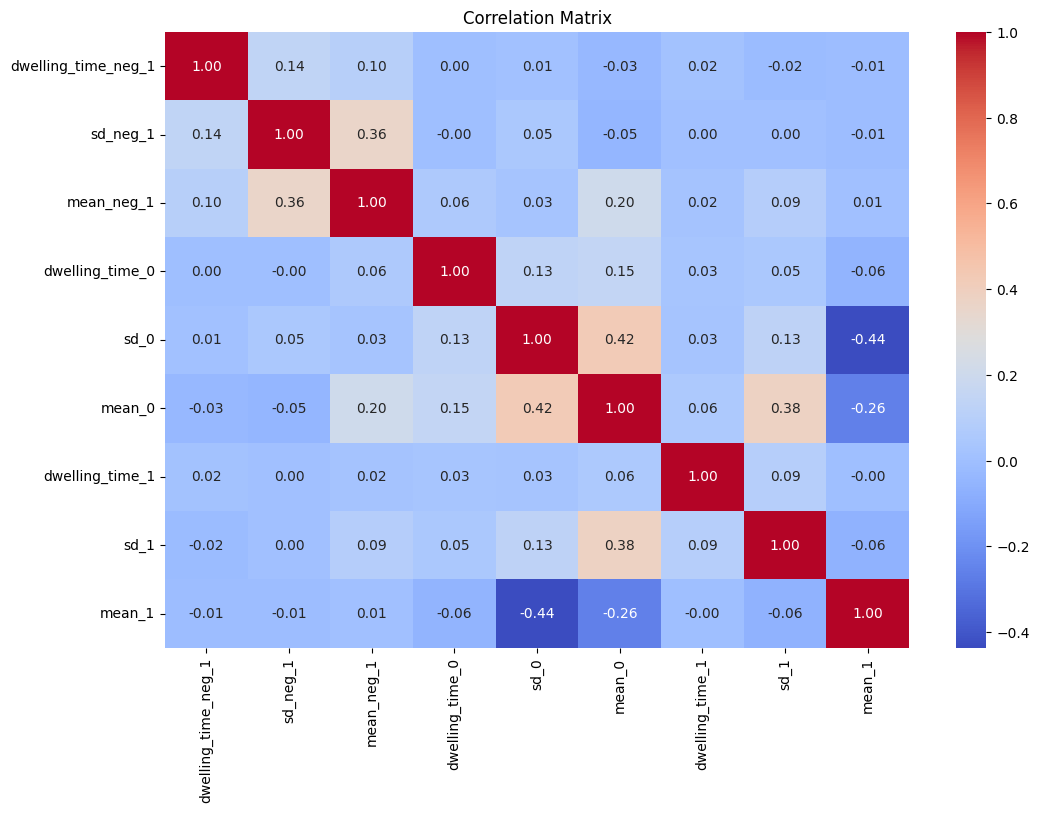

In [28]:
relevant_columns = [
    'dwelling_time_neg_1', 'sd_neg_1', 'mean_neg_1',
    'dwelling_time_0', 'sd_0', 'mean_0',
    'dwelling_time_1', 'sd_1', 'mean_1'
]

for col in relevant_columns:
    merged_df[col] = pd.to_numeric(merged_df[col], errors='coerce')

# Calculate the correlation matrix for relevant columns
correlation_matrix = merged_df[relevant_columns].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# 3. Data Preprocessing (start here)

In [6]:
# Change this file path according to your own
df = pd.read_csv("data/merged_df.csv")
df.head()


,transcript_id,position_neg_1,dwelling_time_neg_1,sd_neg_1,mean_neg_1,transcript_position,dwelling_time_0,sd_0,mean_0,position_1,dwelling_time_1,sd_1,mean_1,ori_nucleotide,fivemer_neg_1,fivemer_0,fivemer_1,gene_id,label
0,ENST00000000233,243,0.00299,2.06,125.0,244,0.01770,10.40,122.0,245,0.00930,10.90,84.1,AAGACCA,AAGAC,AGACC,GACCA,ENSG00000004059,0
1,ENST00000000233,243,0.00631,2.53,125.0,244,0.00844,4.67,126.0,245,0.01030,6.30,80.9,AAGACCA,AAGAC,AGACC,GACCA,ENSG00000004059,0
2,ENST00000000233,243,0.00465,3.92,109.0,244,0.01360,12.00,124.0,245,0.00498,2.13,79.6,AAGACCA,AAGAC,AGACC,GACCA,ENSG00000004059,0
3,ENST00000000233,243,0.00398,2.06,125.0,244,0.00830,5.01,130.0,245,0.00498,3.78,80.4,AAGACCA,AAGAC,AGACC,GACCA,ENSG00000004059,0
4,ENST00000000233,243,0.00664,2.92,120.0,244,0.00266,3.94,129.0,245,0.01300,7.15,82.2,AAGACCA,AAGAC,AGACC,GACCA,ENSG00000004059,0


## 3.1 Drop columns and rename

In [7]:
df = df.drop(columns=["ori_nucleotide","fivemer_neg_1","fivemer_0","fivemer_1"])

# 4. Feature Engineering

In [8]:
columns_to_average = ['dwelling_time_neg_1', 'dwelling_time_0', 'dwelling_time_1', 
                      'mean_neg_1', 'mean_0', 'mean_1', 
                      'sd_neg_1', 'sd_0', 'sd_1']

# Group by 'transcript_id' and 'gene_id' and calculate the mean for each column
averaged_df = df.groupby(['transcript_id', 'gene_id', 'transcript_position']).agg({
    'dwelling_time_neg_1': ['mean', 'min', 'max', 'median'],
    'dwelling_time_0': ['mean', 'min', 'max', 'median'],
    'dwelling_time_1': ['mean', 'min', 'max', 'median'],
    'mean_neg_1': ['mean', 'min', 'max', 'median'],
    'mean_0': ['mean', 'min', 'max', 'median'],
    'mean_1': ['mean', 'min', 'max', 'median'],
    'sd_neg_1': ['mean', 'min', 'max', 'median'],
    'sd_0': ['mean', 'min', 'max', 'median'],
    'sd_1': ['mean', 'min', 'max', 'median'],
    'label': 'first'  # Keep the first value for the 'label' column
}).reset_index()

# Rename columns to desired format
averaged_df.columns = [
    f'{col[0]}_{col[1]}' if col[1] != '' else col[0]  # Join column names with '_'
    for col in averaged_df.columns
]



In [9]:
# rolling difference for mean only
def add_rolling(df):
    # Define the pairs of columns to calculate differences for each metric
    calculations = {
        'dwelling_time': [('dwelling_time_neg_1_mean', 'dwelling_time_0_mean'), 
                          ('dwelling_time_0_mean', 'dwelling_time_1_mean')],
        'mean': [('mean_neg_1_mean', 'mean_0_mean'), 
                 ('mean_0_mean', 'mean_1_mean')],
        'sd': [('sd_neg_1_mean', 'sd_0_mean'), 
               ('sd_0_mean', 'sd_1_mean')]
    }

    for metric, pairs in calculations.items():
        for first, second in pairs:
            # Create a new column with a unique name for the difference
            df[f'{metric}_diff_{first}_{second}'] = df[first] - df[second]
    
    return df

averaged_df = add_rolling(averaged_df)

# 5. Normalise

In [10]:
scaler = StandardScaler()

excluded_columns = ['transcript_id', 'gene_id', 'transcript_position', 'label_first']

scaled_columns = [col for col in averaged_df.columns if col not in excluded_columns]

averaged_df[scaled_columns] = scaler.fit_transform(averaged_df[scaled_columns])

averaged_df.head(50)


,transcript_id,gene_id,transcript_position,dwelling_time_neg_1_mean,dwelling_time_neg_1_min,dwelling_time_neg_1_max,dwelling_time_neg_1_median,dwelling_time_0_mean,dwelling_time_0_min,dwelling_time_0_max,...,sd_1_min,sd_1_max,sd_1_median,label_first,dwelling_time_diff_dwelling_time_neg_1_mean_dwelling_time_0_mean,dwelling_time_diff_dwelling_time_0_mean_dwelling_time_1_mean,mean_diff_mean_neg_1_mean_mean_0_mean,mean_diff_mean_0_mean_mean_1_mean,sd_diff_sd_neg_1_mean_sd_0_mean,sd_diff_sd_0_mean_sd_1_mean
0,ENST00000000233,ENSG00000004059,244,0.087761,-0.677187,0.771469,0.063341,0.736128,-0.115353,0.352157,...,-1.190978,1.723426,0.947048,0,-0.489214,0.494164,-0.141548,1.388004,-0.837533,0.426568
1,ENST00000000233,ENSG00000004059,261,-0.838615,-0.677187,-0.419964,-0.731625,-0.776592,-1.320782,0.049843,...,-1.351208,1.412930,-0.044536,0,-0.082614,-1.015542,0.134296,-0.750868,0.287873,-1.037183
2,ENST00000000233,ENSG00000004059,316,-0.300881,0.016588,0.364142,-0.331154,-0.420555,-1.320782,0.904663,...,-1.586028,-0.194996,-0.997982,0,0.078259,-0.624554,0.460731,-1.021467,0.040486,-0.330007
3,ENST00000000233,ENSG00000004059,332,1.406338,0.016588,1.087148,1.288663,0.298358,0.816116,0.247911,...,-0.884331,-0.274837,-0.711948,0,0.901816,0.753449,2.182904,-1.082121,1.570204,-0.799248
4,ENST00000000233,ENSG00000004059,368,1.451257,-0.677187,2.186932,1.252800,1.980413,-0.115353,0.696170,...,-0.453368,0.239699,1.862356,0,-0.340927,0.201031,-0.266938,0.810745,0.486217,-0.301368
5,ENST00000000233,ENSG00000004059,404,0.505638,0.752410,0.140112,0.726808,0.252933,-0.115353,0.216637,...,-1.453424,-0.802681,-0.858143,0,0.213502,0.870322,2.160165,-1.312238,1.523672,-0.684258
6,ENST00000000233,ENSG00000004059,431,0.322077,-0.677187,1.667589,0.188861,-0.518928,-1.320782,1.457169,...,-0.660562,-0.070797,-0.082674,0,0.652998,-0.857119,-0.298031,0.716302,-0.530580,0.385326
7,ENST00000000233,ENSG00000004059,440,-0.738356,-1.370962,0.975133,-0.528401,0.236024,-0.389314,0.122815,...,-0.688188,0.250788,0.502106,0,-0.771999,0.021948,-1.611406,0.934256,-1.432285,1.920716
8,ENST00000000233,ENSG00000004059,471,-1.146107,-0.572070,0.221577,-1.126119,-0.667773,-0.718067,0.383431,...,-0.679900,-0.498838,-1.150533,0,-0.412120,-0.222732,1.319490,-1.056346,2.103903,-0.558743
9,ENST00000000233,ENSG00000004059,539,1.658093,0.016588,1.525025,1.557636,0.513390,-0.115353,0.279185,...,0.182026,1.058078,0.559313,0,0.940380,0.788092,-0.164848,0.929081,-0.101262,0.728433


# 6. Train-test-split

In [11]:
X = averaged_df.drop(columns=['label_first'])
y = averaged_df['label_first']

groups = averaged_df['gene_id']

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in gss.split(X, y, groups=groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]



In [12]:
X_train = X_train.drop(columns=['transcript_id', 'gene_id','transcript_position'], errors='ignore')
X_test = X_test.drop(columns=['transcript_id', 'gene_id','transcript_position'], errors='ignore')

# 7. Feature Selection via Random Forest

In [13]:
def rf_feature_selector(X, y):
    model = RandomForestClassifier(random_state=42)
    model.fit(X, y)

    importances = model.feature_importances_

    feature_importances = pd.Series(importances, index=X.columns)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importances.sort_values(ascending=False), y=feature_importances.sort_values(ascending=False).index)
    plt.title('Feature Importances from Random Forest')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.show()
    
    top_features = feature_importances.nlargest(10).index.tolist()
    
    X_selected = X[top_features]
    
    return X_selected, top_features

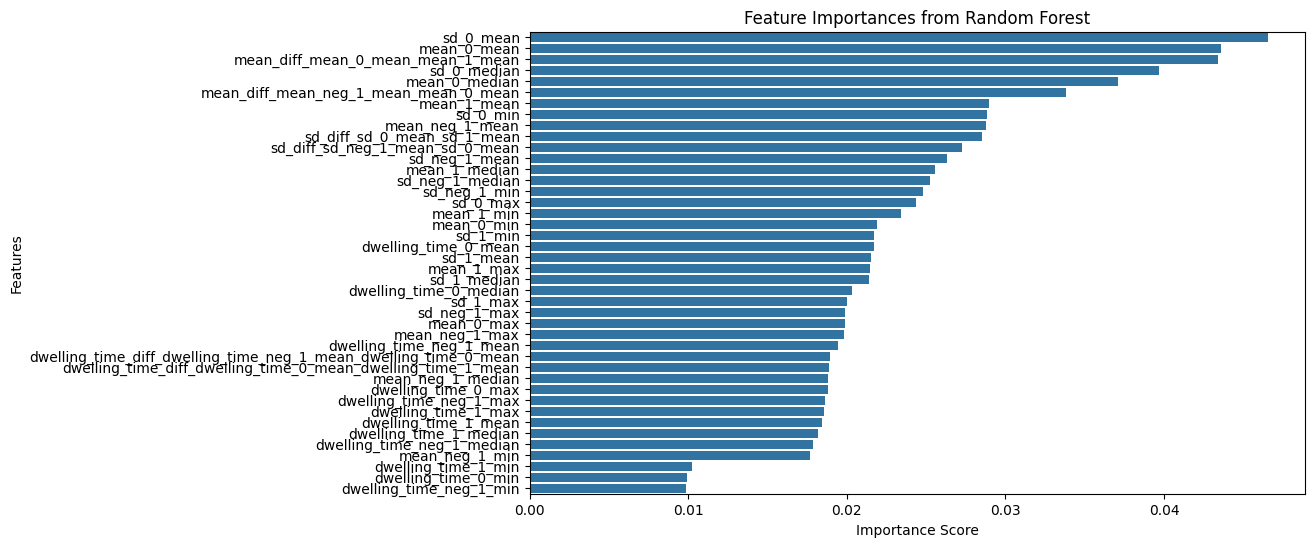

In [14]:
X_selected, top_features = rf_feature_selector(X_train,y_train)

In [15]:
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

# 8. SMOTE for Class Balancing

In [16]:
print("Class distribution in training set before SMOTE:")
print(y_train.value_counts())

# label                                                                           
# 0    93715                                                                      
# 1     4291 

Class distribution in training set before SMOTE:
label_first
0    93715
1     4291
Name: count, dtype: int64


In [17]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
X_train_selected_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)
print("Class distribution in training set after SMOTE:")
print(pd.Series(y_train_resampled).value_counts())
#  Both Label 0 and 1: 93715 each                                                                       

Class distribution in training set after SMOTE:
label_first
0    93715
1    93715
Name: count, dtype: int64


# 9. Model Training

In [109]:
pipelines = {
    'logistic': make_pipeline(StandardScaler(), LogisticRegression(max_iter=200,random_state=42)),
    'rf': make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, random_state=42)),
    'gb': make_pipeline(StandardScaler(), GradientBoostingClassifier(n_estimators=100, random_state=42)),
    'xgb': make_pipeline(StandardScaler(), xgb.XGBClassifier(n_estimators=100, random_state=42)),
    'svm': make_pipeline(StandardScaler(), SVC())
}

In [110]:
print("Training and evaluating models with all features:")
for name, pipeline in pipelines.items():
    pipeline.fit(X_train_resampled, y_train_resampled)
    train_score = pipeline.score(X_train_resampled, y_train_resampled)
    print(f"{name}: Training Score: {train_score}")

Training and evaluating models with all features:
rf: Training Score: 1.0


In [111]:
pipelines_selected = {name: copy.deepcopy(pipeline) for name, pipeline in pipelines.items()}

print("\nTraining and evaluating models with selected features:")
for name, pipeline in pipelines_selected.items():
    pipeline.fit(X_train_selected_resampled, y_train_resampled)
    train_score = pipeline.score(X_train_selected_resampled, y_train_resampled)
    print(f"{name}: Training Score: {train_score}")


Training and evaluating models with selected features:
rf: Training Score: 1.0


# 10. Model Evaluation

## 10.1 Test with all features

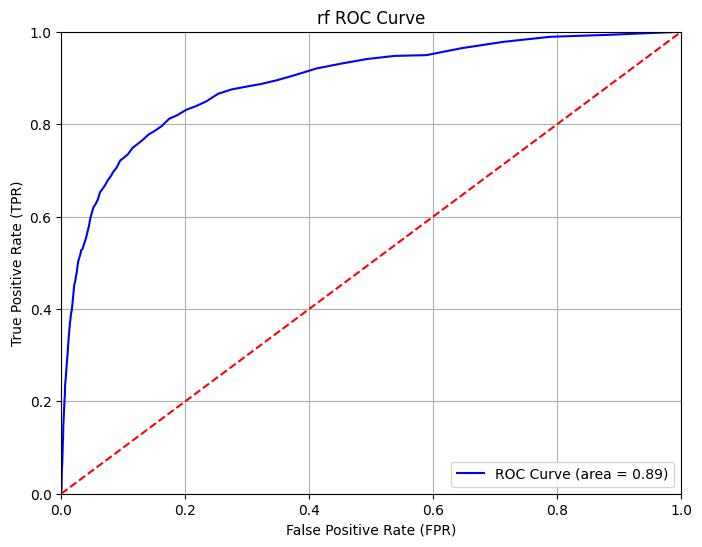

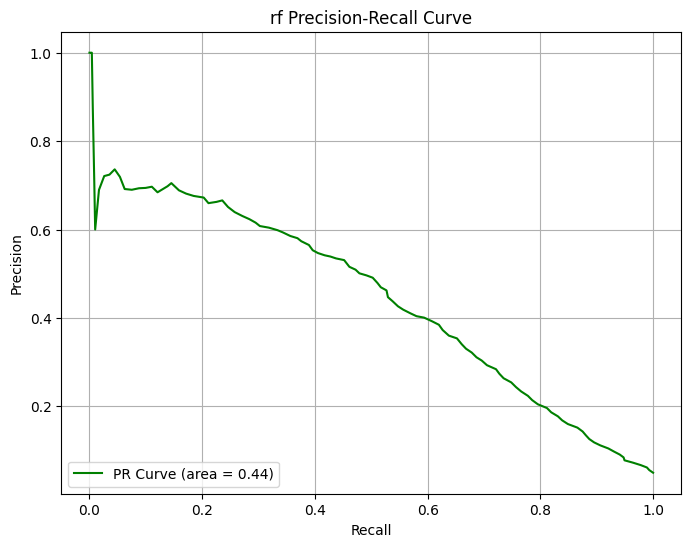


Confusion Matrix for rf:
 [[22031   617]
 [  589   595]]
Accuracy:
rf: 0.9493957703927492

Precision:
rf: 0.4909240924092409

Recall:
rf: 0.5025337837837838

F1:
rf: 0.496661101836394

ROCAUC:
rf: 0.8907387040320963

PRAUC:
rf: 0.4442081892699356


In [37]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
pr_auc_scores = []

for name, pipeline in pipelines.items():

    y_pred = pipeline.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    y_probs = pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    precision1, recall1, _ = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(recall1, precision1)

    accuracy_scores.append((name, accuracy))
    precision_scores.append((name, precision))
    recall_scores.append((name, recall))
    f1_scores.append((name, f1))
    roc_auc_scores.append((name, roc_auc))
    pr_auc_scores.append((name, pr_auc))

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'{name} ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(recall1, precision1, color='green', label='PR Curve (area = {:.2f})'.format(pr_auc))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{name} Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid()
    plt.show()

    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix for {name}:\n", cm)


print("Accuracy:")
for name, score in accuracy_scores:
    print(f"{name}: {score}")

print("\nPrecision:")
for name, score in precision_scores:
    print(f"{name}: {score}")

print("\nRecall:")
for name, score in recall_scores:
    print(f"{name}: {score}")

print("\nF1:")
for name, score in f1_scores:
    print(f"{name}: {score}")

print("\nROCAUC:")
for name, score in roc_auc_scores:
    print(f"{name}: {score}")

print("\nPRAUC:")
for name, score in pr_auc_scores:
    print(f"{name}: {score}")

/var/folders/7v/vz0y39qn3xgd4vmbsq63r7dw0000gn/T/ipykernel_29720/1686199015.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=45)
/var/folders/7v/vz0y39qn3xgd4vmbsq63r7dw0000gn/T/ipykernel_29720/1686199015.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=45)
/var/folders/7v/vz0y39qn3xgd4vmbsq63r7dw0000gn/T/ipykernel_29720/1686199015.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=45)
/var/folders/7v/vz0y39qn3xgd4vmbsq63r7dw0000gn/T/ipykernel_29720/1686199015.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, r

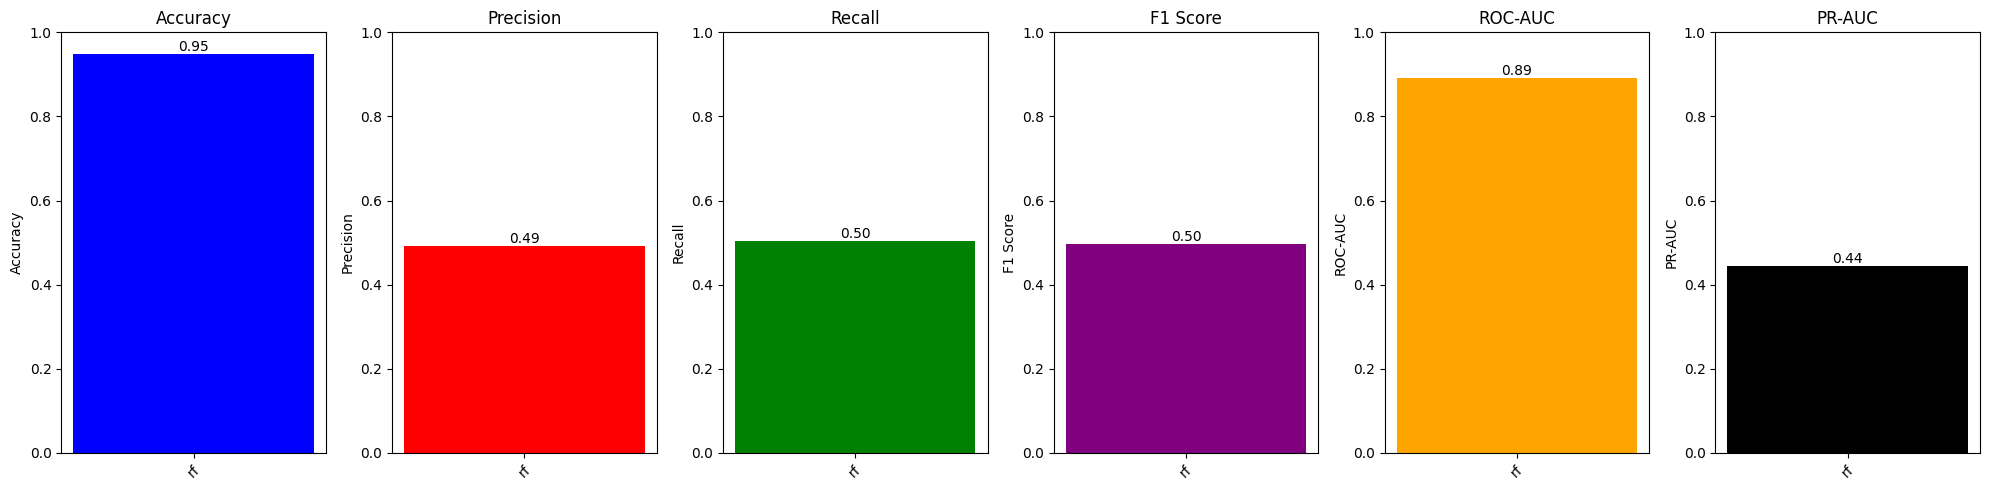

In [38]:
models = [name for name, _ in accuracy_scores]
accuracy_values = [score for _, score in accuracy_scores]
precision_values = [score for _, score in precision_scores]
recall_values = [score for _, score in recall_scores]
f1_values = [score for _, score in f1_scores]
roc_auc_values = [score for _, score in roc_auc_scores]
pr_auc_values = [score for _, score in pr_auc_scores]

fig, axes = plt.subplots(1, 6, figsize=(20, 5))

def add_value_labels(ax, bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', 
                ha='center', va='bottom', fontsize=10)

# Plot Accuracy
bars_acc = axes[0].bar(models, accuracy_values, color='blue')
axes[0].set_title('Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(0, 1)  # Set y-limits for better visual comparison
add_value_labels(axes[0], bars_acc)  # Add value labels for Accuracy

# Plot Precision
bars_prec = axes[1].bar(models, precision_values, color='red')
axes[1].set_title('Precision')
axes[1].set_ylabel('Precision')
axes[1].set_ylim(0, 1)
add_value_labels(axes[1], bars_prec)  # Add value labels for Precision

# Plot Recall
bars_recall = axes[2].bar(models, recall_values, color='green')
axes[2].set_title('Recall')
axes[2].set_ylabel('Recall')
axes[2].set_ylim(0, 1)
add_value_labels(axes[2], bars_recall)  # Add value labels for Recall

# Plot F1 Score
bars_f1 = axes[3].bar(models, f1_values, color='purple')
axes[3].set_title('F1 Score')
axes[3].set_ylabel('F1 Score')
axes[3].set_ylim(0, 1)
add_value_labels(axes[3], bars_f1)  # Add value labels for F1 Score

# Plot ROC-AUC
bars_roc_auc = axes[4].bar(models, roc_auc_values, color='orange')
axes[4].set_title('ROC-AUC')
axes[4].set_ylabel('ROC-AUC')
axes[4].set_ylim(0, 1)
add_value_labels(axes[4], bars_roc_auc)  # Add value labels for AUC

# Plot PR-AUC
bars_pr_auc = axes[5].bar(models, pr_auc_values, color='black')
axes[5].set_title('PR-AUC')
axes[5].set_ylabel('PR-AUC')
axes[5].set_ylim(0, 1)
add_value_labels(axes[5], bars_pr_auc)  # Add value labels for AUC

# Rotate x-axis labels for better readability
for ax in axes:
    ax.set_xticklabels(models, rotation=45)

plt.tight_layout()

plt.show()

## 10.2 Test with selected features

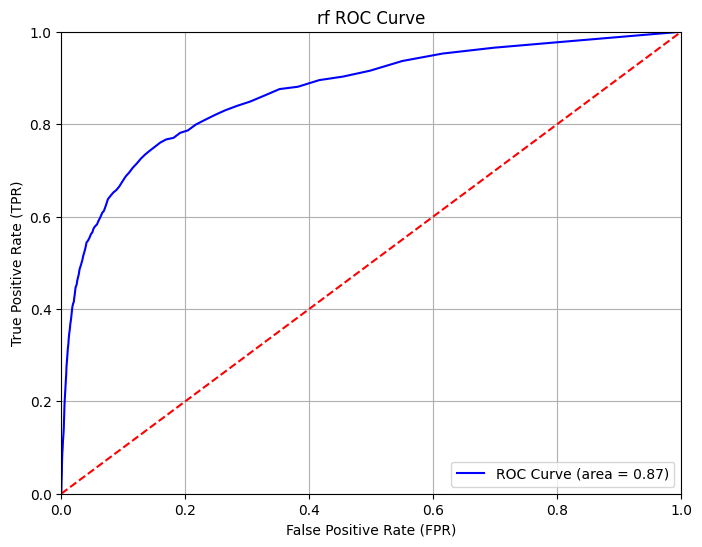

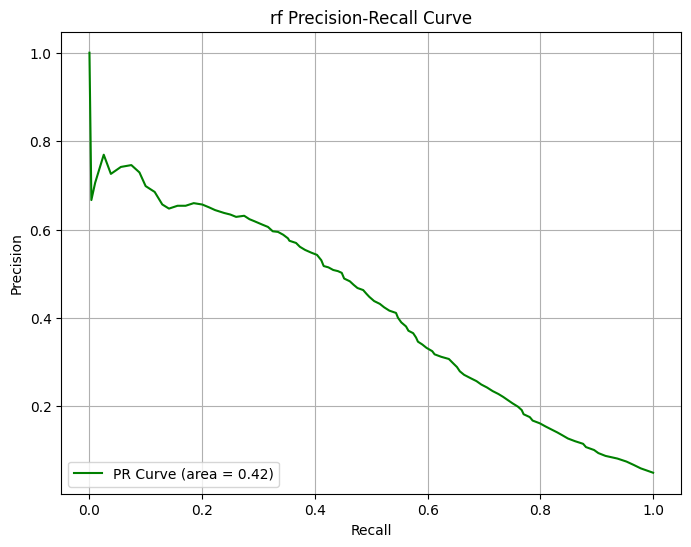


Confusion Matrix for rf:
 [[21845   803]
 [  574   610]]
Accuracy:
rf: 0.9422205438066465

Precision:
rf: 0.4317055909412597

Recall:
rf: 0.5152027027027027

F1:
rf: 0.46977281478629185

ROCAUC):
rf: 0.869736368493847

PRAUC):
rf: 0.41946416295782923


In [39]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
pr_auc_scores = []

for name, pipeline in pipelines_selected.items():

    y_pred = pipeline.predict(X_test_selected)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    y_probs = pipeline.predict_proba(X_test_selected)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)
    precision1, recall1, _ = precision_recall_curve(y_test, y_probs)
    pr_auc = auc(recall1, precision1)

    accuracy_scores.append((name, accuracy))
    precision_scores.append((name, precision))
    recall_scores.append((name, recall))
    f1_scores.append((name, f1))
    roc_auc_scores.append((name, roc_auc))
    pr_auc_scores.append((name, pr_auc))

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'{name} ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    plt.figure(figsize=(8, 6))
    plt.plot(recall1, precision1, color='green', label='PR Curve (area = {:.2f})'.format(pr_auc))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{name} Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.grid()
    plt.show()

    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix for {name}:\n", cm)


print("Accuracy:")
for name, score in accuracy_scores:
    print(f"{name}: {score}")

print("\nPrecision:")
for name, score in precision_scores:
    print(f"{name}: {score}")

print("\nRecall:")
for name, score in recall_scores:
    print(f"{name}: {score}")

print("\nF1:")
for name, score in f1_scores:
    print(f"{name}: {score}")

print("\nROCAUC):")
for name, score in roc_auc_scores:
    print(f"{name}: {score}")

print("\nPRAUC):")
for name, score in pr_auc_scores:
    print(f"{name}: {score}")

/var/folders/7v/vz0y39qn3xgd4vmbsq63r7dw0000gn/T/ipykernel_29720/1686199015.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=45)
/var/folders/7v/vz0y39qn3xgd4vmbsq63r7dw0000gn/T/ipykernel_29720/1686199015.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=45)
/var/folders/7v/vz0y39qn3xgd4vmbsq63r7dw0000gn/T/ipykernel_29720/1686199015.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=45)
/var/folders/7v/vz0y39qn3xgd4vmbsq63r7dw0000gn/T/ipykernel_29720/1686199015.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, r

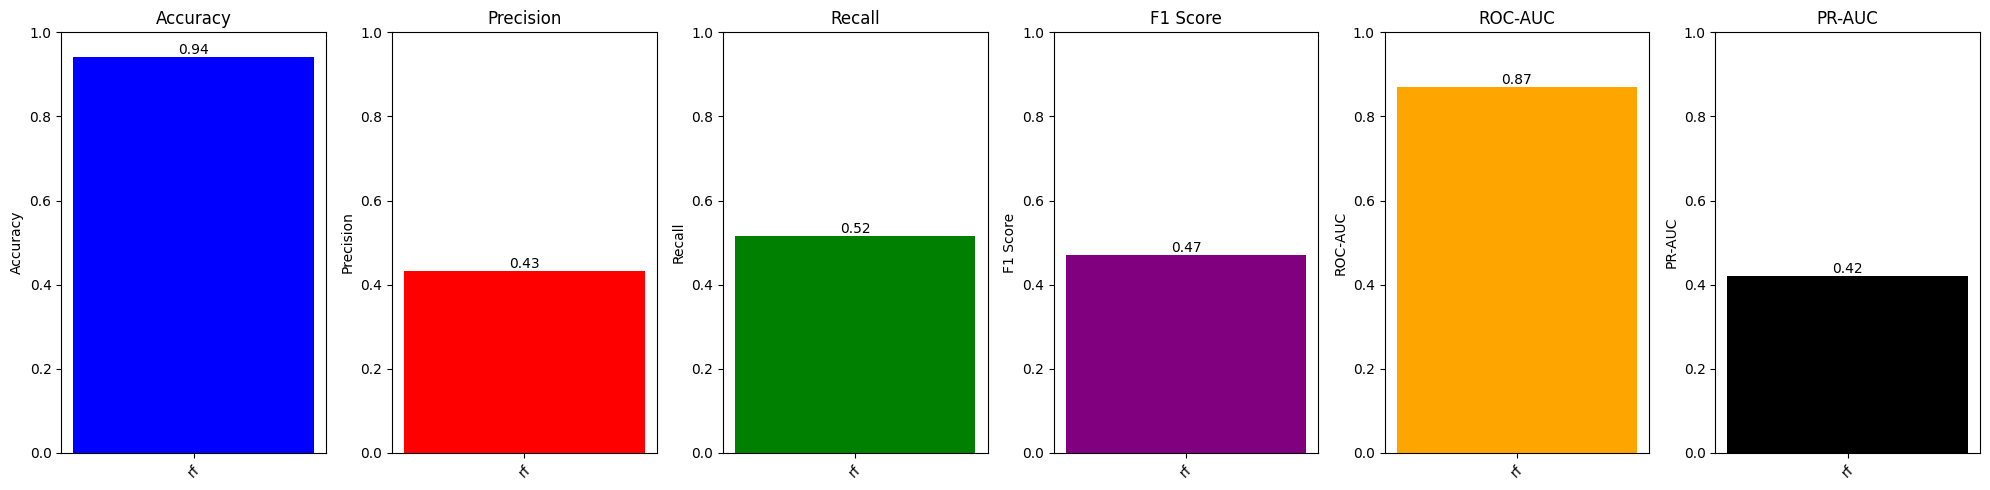

In [40]:
models = [name for name, _ in accuracy_scores]
accuracy_values = [score for _, score in accuracy_scores]
precision_values = [score for _, score in precision_scores]
recall_values = [score for _, score in recall_scores]
f1_values = [score for _, score in f1_scores]
roc_auc_values = [score for _, score in roc_auc_scores]
pr_auc_values = [score for _, score in pr_auc_scores]

fig, axes = plt.subplots(1, 6, figsize=(20, 5))

def add_value_labels(ax, bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval, f'{yval:.2f}', 
                ha='center', va='bottom', fontsize=10)

# Plot Accuracy
bars_acc = axes[0].bar(models, accuracy_values, color='blue')
axes[0].set_title('Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(0, 1)  # Set y-limits for better visual comparison
add_value_labels(axes[0], bars_acc)  # Add value labels for Accuracy

# Plot Precision
bars_prec = axes[1].bar(models, precision_values, color='red')
axes[1].set_title('Precision')
axes[1].set_ylabel('Precision')
axes[1].set_ylim(0, 1)
add_value_labels(axes[1], bars_prec)  # Add value labels for Precision

# Plot Recall
bars_recall = axes[2].bar(models, recall_values, color='green')
axes[2].set_title('Recall')
axes[2].set_ylabel('Recall')
axes[2].set_ylim(0, 1)
add_value_labels(axes[2], bars_recall)  # Add value labels for Recall

# Plot F1 Score
bars_f1 = axes[3].bar(models, f1_values, color='purple')
axes[3].set_title('F1 Score')
axes[3].set_ylabel('F1 Score')
axes[3].set_ylim(0, 1)
add_value_labels(axes[3], bars_f1)  # Add value labels for F1 Score

# Plot ROC-AUC
bars_roc_auc = axes[4].bar(models, roc_auc_values, color='orange')
axes[4].set_title('ROC-AUC')
axes[4].set_ylabel('ROC-AUC')
axes[4].set_ylim(0, 1)
add_value_labels(axes[4], bars_roc_auc)  # Add value labels for AUC

# Plot PR-AUC
bars_pr_auc = axes[5].bar(models, pr_auc_values, color='black')
axes[5].set_title('PR-AUC')
axes[5].set_ylabel('PR-AUC')
axes[5].set_ylim(0, 1)
add_value_labels(axes[5], bars_pr_auc)  # Add value labels for AUC

# Rotate x-axis labels for better readability
for ax in axes:
    ax.set_xticklabels(models, rotation=45)

plt.tight_layout()

plt.show()

# 11. Trying out Feed-Forward Neural Network

## 11.1 Test with all features

In [124]:
class PrintEpochStatus(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f'Epoch {epoch + 1}/{self.params["epochs"]}: '
              f'Loss: {logs["loss"]:.4f}, '
              f'ROC AUC: {logs["auc"]:.4f}, '
              f'PR AUC: {logs["pr_auc"]:.4f}, '
              f'Validation Loss: {logs["val_loss"]:.4f}, '
              f'Validation ROC AUC: {logs["val_auc"]:.4f}, '
              f'Validation PR AUC: {logs["val_pr_auc"]:.4f}')

class_weights = class_weight.compute_class_weight('balanced', 
                                                  classes=np.unique(y_train_resampled), 
                                                  y=y_train_resampled)

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_resampled.shape[1],)))  # Input layer
model.add(Dropout(0.3))  # Dropout to prevent overfitting
model.add(Dense(64, activation='relu'))  # Hidden layer
model.add(Dropout(0.3))  # Dropout layer
model.add(Dense(32, activation='relu'))  # Hidden layer
model.add(Dense(1, activation='sigmoid'))  # Output layer (binary classification)

# Compile the model using 'roc_auc' and 'pr_auc' as metrics
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=[AUC(name='auc', curve='ROC'), AUC(name='pr_auc', curve='PR')])

# Set up early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.01)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_delta=0.01, min_lr=1e-6)

history = model.fit(X_train_resampled, y_train_resampled, 
                    epochs=500,               
                    batch_size=32,            # Adjust based on memory capacity
                    validation_split=0.2,     # Use 20% of training data for validation
                    #callbacks=[PrintEpochStatus()],
                    #class_weight={0: class_weights[0], 1: class_weights[1]},  # Apply class weights
                    callbacks=[early_stopping, PrintEpochStatus(), lr_scheduler],
                    verbose=0)  # Set verbose=0 to disable the default logging

# Evaluate the model on the test set
test_loss, test_auc, test_pr_auc = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}, Test ROC AUC: {test_auc}, Test PR AUC: {test_pr_auc}')

# Save the model in the TensorFlow SavedModel format
model.save('ffnn.keras')

/Users/I749625/Documents/veritasai-ui/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500: Loss: 0.4205, ROC AUC: 0.8784, PR AUC: 0.8190, Validation Loss: 0.4596, Validation ROC AUC: 0.0000, Validation PR AUC: 1.0000
Epoch 2/500: Loss: 0.3628, ROC AUC: 0.9111, PR AUC: 0.8661, Validation Loss: 0.4361, Validation ROC AUC: 0.0000, Validation PR AUC: 1.0000
Epoch 3/500: Loss: 0.3408, ROC AUC: 0.9223, PR AUC: 0.8804, Validation Loss: 0.4406, Validation ROC AUC: 0.0000, Validation PR AUC: 1.0000
Epoch 4/500: Loss: 0.3266, ROC AUC: 0.9290, PR AUC: 0.8889, Validation Loss: 0.3100, Validation ROC AUC: 0.0000, Validation PR AUC: 1.0000
Epoch 5/500: Loss: 0.3165, ROC AUC: 0.9337, PR AUC: 0.8944, Validation Loss: 0.4232, Validation ROC AUC: 0.0000, Validation PR AUC: 1.0000
Epoch 6/500: Loss: 0.3088, ROC AUC: 0.9370, PR AUC: 0.8992, Validation Loss: 0.2896, Validation ROC AUC: 0.0000, Validation PR AUC: 1.0000
Epoch 7/500: Loss: 0.3018, ROC AUC: 0.9400, PR AUC: 0.9022, Validation Loss: 0.3586, Validation ROC AUC: 0.0000, Validation PR AUC: 1.0000
Epoch 8/500: Loss: 0.2971, 

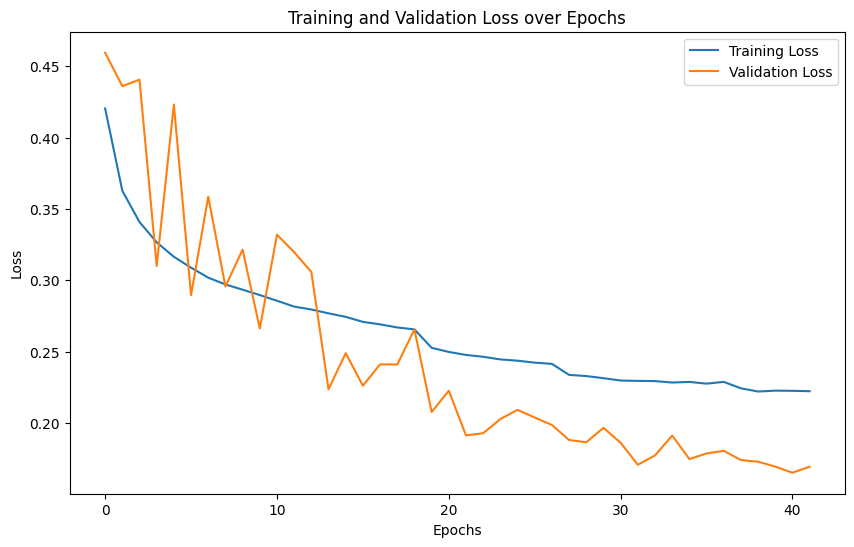

In [125]:
# Extract the loss and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a figure and plot
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(train_loss, label='Training Loss')

# Plot validation loss
plt.plot(val_loss, label='Validation Loss')

# Add labels, title, and legend
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plot
plt.show()

## 11.2 Test with selected features

In [126]:
class PrintEpochStatus(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f'Epoch {epoch + 1}/{self.params["epochs"]}: '
              f'Loss: {logs["loss"]:.4f}, '
              f'ROC AUC: {logs["auc"]:.4f}, '
              f'PR AUC: {logs["pr_auc"]:.4f}, '
              f'Validation Loss: {logs["val_loss"]:.4f}, '
              f'Validation ROC AUC: {logs["val_auc"]:.4f}, '
              f'Validation PR AUC: {logs["val_pr_auc"]:.4f}')

class_weights = class_weight.compute_class_weight('balanced', 
                                                  classes=np.unique(y_train_resampled), 
                                                  y=y_train_resampled)

model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train_selected_resampled.shape[1],)))  # Input layer
model.add(Dropout(0.3))  # Dropout to prevent overfitting
model.add(Dense(64, activation='relu'))  # Hidden layer
model.add(Dropout(0.3))  # Dropout layer
model.add(Dense(32, activation='relu'))  # Hidden layer
model.add(Dense(1, activation='sigmoid'))  # Output layer (binary classification)

# Compile the model using 'roc_auc' and 'pr_auc' as metrics
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=[AUC(name='auc', curve='ROC'), AUC(name='pr_auc', curve='PR')])

# Set up early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.001)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_delta=0.001, min_lr=1e-6)

history = model.fit(X_train_selected_resampled, y_train_resampled, 
                    epochs=500,               
                    batch_size=32,            # Adjust based on memory capacity
                    validation_split=0.2,     # Use 20% of training data for validation
                    #callbacks=[PrintEpochStatus()],
                    #class_weight={0: class_weights[0], 1: class_weights[1]},  # Apply class weights
                    callbacks=[early_stopping, PrintEpochStatus(), lr_scheduler],
                    verbose=0)  # Set verbose=0 to disable the default logging

# Evaluate the model on the test set
test_loss, test_auc, test_pr_auc = model.evaluate(X_test_selected, y_test)
print(f'Test Loss: {test_loss}, Test ROC AUC: {test_auc}, Test PR AUC: {test_pr_auc}')

# Save the model in the TensorFlow SavedModel format
model.save('ffnn_selected.keras')

/Users/I749625/Documents/veritasai-ui/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500: Loss: 0.4427, ROC AUC: 0.8603, PR AUC: 0.8069, Validation Loss: 0.4819, Validation ROC AUC: 0.0000, Validation PR AUC: 1.0000
Epoch 2/500: Loss: 0.4118, ROC AUC: 0.8807, PR AUC: 0.8323, Validation Loss: 0.5304, Validation ROC AUC: 0.0000, Validation PR AUC: 1.0000
Epoch 3/500: Loss: 0.4044, ROC AUC: 0.8856, PR AUC: 0.8375, Validation Loss: 0.5360, Validation ROC AUC: 0.0000, Validation PR AUC: 1.0000
Epoch 4/500: Loss: 0.3992, ROC AUC: 0.8886, PR AUC: 0.8408, Validation Loss: 0.5176, Validation ROC AUC: 0.0000, Validation PR AUC: 1.0000
Epoch 5/500: Loss: 0.3967, ROC AUC: 0.8904, PR AUC: 0.8430, Validation Loss: 0.4282, Validation ROC AUC: 0.0000, Validation PR AUC: 1.0000
Epoch 6/500: Loss: 0.3938, ROC AUC: 0.8923, PR AUC: 0.8446, Validation Loss: 0.5611, Validation ROC AUC: 0.0000, Validation PR AUC: 1.0000
Epoch 7/500: Loss: 0.3911, ROC AUC: 0.8939, PR AUC: 0.8471, Validation Loss: 0.5254, Validation ROC AUC: 0.0000, Validation PR AUC: 1.0000
Epoch 8/500: Loss: 0.3895, 

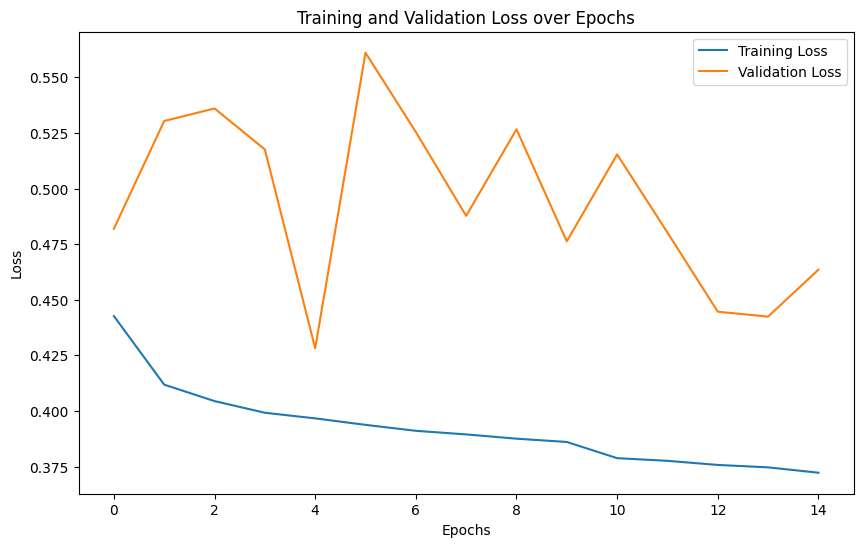

In [127]:
# Extract the loss and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a figure and plot
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(train_loss, label='Training Loss')

# Plot validation loss
plt.plot(val_loss, label='Validation Loss')

# Add labels, title, and legend
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plot
plt.show()

# 12. Trying out Convolutional Neural Network (CNN)

## 12.1 Test with all features

In [128]:
class PrintEpochStatus(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f'Epoch {epoch + 1}/{self.params["epochs"]}: '
              f'Loss: {logs["loss"]:.4f}, '
              f'ROC AUC: {logs["auc"]:.4f}, '
              f'PR AUC: {logs["pr_auc"]:.4f}, '
              f'Validation Loss: {logs["val_loss"]:.4f}, '
              f'Validation ROC AUC: {logs["val_auc"]:.4f}, '
              f'Validation PR AUC: {logs["val_pr_auc"]:.4f}')

class_weights = class_weight.compute_class_weight('balanced', 
                                                  classes=np.unique(y_train_resampled), 
                                                  y=y_train_resampled)

# Reshape input data for 1D CNN (assuming X_train_resampled is in 2D (samples, features))
X_train_reshaped = np.expand_dims(X_train_resampled, axis=2)  # Add a "channel" dimension for CNN
X_test_reshaped = np.expand_dims(X_test, axis=2)


model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))  # Conv layer
model.add(MaxPooling1D(pool_size=2))  # Pooling layer
model.add(Dropout(0.3))  # Dropout to prevent overfitting
model.add(Conv1D(128, kernel_size=3, activation='relu'))  # Conv layer
model.add(MaxPooling1D(pool_size=2))  # Pooling layer
model.add(Dropout(0.3))  # Dropout layer

# Flatten the output to feed into Dense layers
model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model using 'roc_auc' and 'pr_auc' as metrics
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=[AUC(name='auc', curve='ROC'), AUC(name='pr_auc', curve='PR')])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.01)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_delta=0.01, min_lr=1e-6)

history = model.fit(X_train_reshaped, y_train_resampled, 
                    epochs=200,
                    batch_size=32, 
                    validation_split=0.2,  # 20% for validation
                    #callbacks=[PrintEpochStatus()],
                    callbacks=[early_stopping, PrintEpochStatus(), lr_scheduler],
                    verbose=0)

# Evaluate the model on the test set
test_loss, test_auc, test_pr_auc = model.evaluate(X_test_reshaped, y_test)
print(f'Test Loss: {test_loss}, Test ROC AUC: {test_auc}, Test PR AUC: {test_pr_auc}')

model.save('cnn.keras')

/Users/I749625/Documents/veritasai-ui/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200: Loss: 0.4112, ROC AUC: 0.8839, PR AUC: 0.8292, Validation Loss: 0.4220, Validation ROC AUC: 0.0000, Validation PR AUC: 1.0000
Epoch 2/200: Loss: 0.3578, ROC AUC: 0.9144, PR AUC: 0.8690, Validation Loss: 0.5050, Validation ROC AUC: 0.0000, Validation PR AUC: 1.0000
Epoch 3/200: Loss: 0.3392, ROC AUC: 0.9236, PR AUC: 0.8811, Validation Loss: 0.2916, Validation ROC AUC: 0.0000, Validation PR AUC: 1.0000
Epoch 4/200: Loss: 0.3246, ROC AUC: 0.9305, PR AUC: 0.8891, Validation Loss: 0.3561, Validation ROC AUC: 0.0000, Validation PR AUC: 1.0000
Epoch 5/200: Loss: 0.3131, ROC AUC: 0.9356, PR AUC: 0.8966, Validation Loss: 0.3070, Validation ROC AUC: 0.0000, Validation PR AUC: 1.0000
Epoch 6/200: Loss: 0.3034, ROC AUC: 0.9396, PR AUC: 0.9021, Validation Loss: 0.1968, Validation ROC AUC: 0.0000, Validation PR AUC: 1.0000
Epoch 7/200: Loss: 0.2956, ROC AUC: 0.9428, PR AUC: 0.9056, Validation Loss: 0.2640, Validation ROC AUC: 0.0000, Validation PR AUC: 1.0000
Epoch 8/200: Loss: 0.2889, 

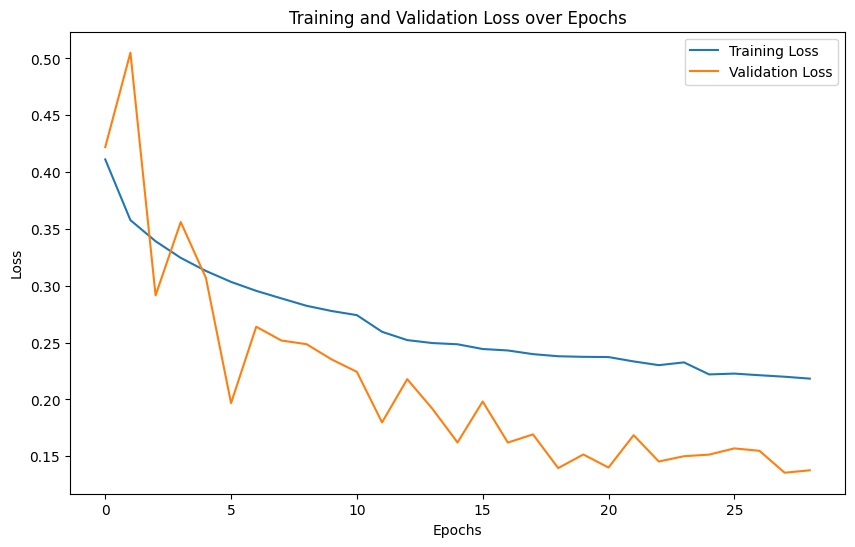

In [129]:
# Extract the loss and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a figure and plot
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(train_loss, label='Training Loss')

# Plot validation loss
plt.plot(val_loss, label='Validation Loss')

# Add labels, title, and legend
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plot
plt.show()

## 12.2 Test with selected features

In [40]:
class PrintEpochStatus(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f'Epoch {epoch + 1}/{self.params["epochs"]}: '
              f'Loss: {logs["loss"]:.4f}, '
              f'ROC AUC: {logs["auc"]:.4f}, '
              f'PR AUC: {logs["pr_auc"]:.4f}, '
              f'Validation Loss: {logs["val_loss"]:.4f}, '
              f'Validation ROC AUC: {logs["val_auc"]:.4f}, '
              f'Validation PR AUC: {logs["val_pr_auc"]:.4f}')

class_weights = class_weight.compute_class_weight('balanced', 
                                                  classes=np.unique(y_train_resampled), 
                                                  y=y_train_resampled)

# Reshape input data for 1D CNN (assuming X_train_resampled is in 2D (samples, features))
X_train_reshaped = np.expand_dims(X_train_selected_resampled, axis=2)  # Add a "channel" dimension for CNN
X_test_reshaped = np.expand_dims(X_test_selected, axis=2)

model = Sequential()
model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)))  # Conv layer
model.add(MaxPooling1D(pool_size=2))  # Pooling layer
model.add(Dropout(0.3))  # Dropout to prevent overfitting
model.add(Conv1D(128, kernel_size=3, activation='relu'))  # Conv layer
model.add(MaxPooling1D(pool_size=2))  # Pooling layer
model.add(Dropout(0.3))  # Dropout layer
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model using 'roc_auc' and 'pr_auc' as metrics
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=[AUC(name='auc', curve='ROC'), AUC(name='pr_auc', curve='PR')])

early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, min_delta=0.0001)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_delta=0.01, min_lr=1e-6)

history = model.fit(X_train_reshaped, y_train_resampled, 
                    epochs=200,
                    batch_size=32, 
                    validation_split=0.2,  # 20% for validation
                    #callbacks=[PrintEpochStatus()],
                    callbacks=[early_stopping, PrintEpochStatus(), lr_scheduler],
                    verbose=0)

# Evaluate the model on the test set
test_loss, test_auc, test_pr_auc = model.evaluate(X_test_reshaped, y_test)
print(f'Test Loss: {test_loss}, Test ROC AUC: {test_auc}, Test PR AUC: {test_pr_auc}')

model.save('cnn_selected.keras')
model.save('cnn_selected.h5')
model.save('cnn_selected', save_format='tf')

Epoch 1/200: Loss: 0.4439, ROC AUC: 0.8590, PR AUC: 0.8064, Validation Loss: 0.5510, Validation ROC AUC: 0.0000, Validation PR AUC: 1.0000
Epoch 2/200: Loss: 0.4171, ROC AUC: 0.8777, PR AUC: 0.8284, Validation Loss: 0.5973, Validation ROC AUC: 0.0000, Validation PR AUC: 1.0000
Epoch 3/200: Loss: 0.4093, ROC AUC: 0.8828, PR AUC: 0.8344, Validation Loss: 0.5862, Validation ROC AUC: 0.0000, Validation PR AUC: 1.0000
Epoch 4/200: Loss: 0.4044, ROC AUC: 0.8864, PR AUC: 0.8370, Validation Loss: 0.5467, Validation ROC AUC: 0.0000, Validation PR AUC: 1.0000
Epoch 5/200: Loss: 0.4010, ROC AUC: 0.8884, PR AUC: 0.8405, Validation Loss: 0.5232, Validation ROC AUC: 0.0000, Validation PR AUC: 1.0000
Epoch 6/200: Loss: 0.3985, ROC AUC: 0.8899, PR AUC: 0.8416, Validation Loss: 0.5514, Validation ROC AUC: 0.0000, Validation PR AUC: 1.0000
Epoch 7/200: Loss: 0.3959, ROC AUC: 0.8917, PR AUC: 0.8433, Validation Loss: 0.5604, Validation ROC AUC: 0.0000, Validation PR AUC: 1.0000
Epoch 8/200: Loss: 0.3940, 

/Users/louise_1/Documents/m6a-detection-project/new_env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: cnn_selected/assets


INFO:tensorflow:Assets written to: cnn_selected/assets


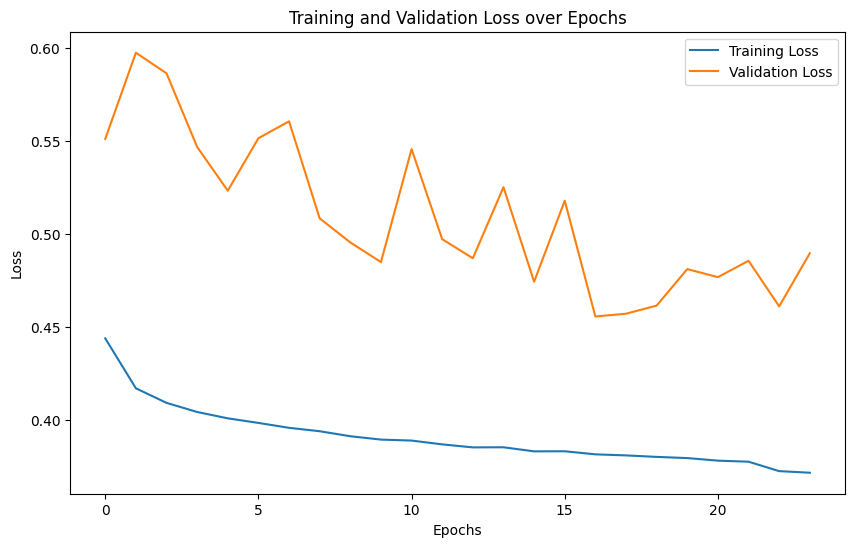

In [41]:
# Extract the loss and validation loss from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a figure and plot
plt.figure(figsize=(10, 6))

# Plot training loss
plt.plot(train_loss, label='Training Loss')

# Plot validation loss
plt.plot(val_loss, label='Validation Loss')

# Add labels, title, and legend
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plot
plt.show()

# 13. Other Experiments that did not work

### Hyperparameter Tuning

add in logistic regression

In [ ]:
# Setting up parameter distributions for each tunable classifier
param_distributions = {
    # 'logistic': {
    #     'logisticregression__C': uniform(0.01, 10),  # Testing values from 0.01 to 10
    #     'logisticregression__penalty': ['l1', 'l2'],   # Using L1 or L2 regularization
    #     'logisticregression__solver': ['liblinear', 'lbfgs'],  # Choosing solver
    #     'logisticregression__max_iter': randint(100, 500),  # Maximum iterations for convergence
    #     'logisticregression__tol': uniform(1e-5, 1e-3)  # Tolerance for stopping criteria
    # },
    'rf': {
        'randomforestclassifier__n_estimators': randint(100, 500),
        'randomforestclassifier__max_features': uniform(0.1, 0.9),
        'randomforestclassifier__max_depth': randint(3, 30),
        'randomforestclassifier__min_samples_split': randint(2, 20),
        'randomforestclassifier__min_samples_leaf': randint(1, 20)
    },
    # 'gb': {
    #     'gradientboostingclassifier__n_estimators': randint(100, 500),
    #     'gradientboostingclassifier__learning_rate': uniform(0.01, 0.3),
    #     'gradientboostingclassifier__max_depth': randint(3, 15)
    # },
    # 'xgb': {
    #     'xgbclassifier__n_estimators': randint(100, 500),
    #     'xgbclassifier__learning_rate': uniform(0.01, 0.3),
    #     'xgbclassifier__max_depth': randint(3, 15),
    #     'xgbclassifier__min_child_weight': randint(1, 10),
    #     'xgbclassifier__colsample_bytree': uniform(0.5, 0.5)
    # },
    # 'svm': {
    #     'svc__C': uniform(0.1, 10),
    #     'svc__gamma': ['scale', 'auto'],
    #     'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    # }
}


In [ ]:
def optimize_pipelines(pipelines, param_distributions, X_train_selected, y_train):
    optimized_pipelines = {}

    # Perform hyperparameter tuning for each model
    for name, pipeline in pipelines.items():
        if name in param_distributions:
            print(f"Tuning hyperparameters for {name}...")
            # Create RandomizedSearchCV object
            # scoring=make_scorer(recall_score)
            random_search = RandomizedSearchCV(pipeline, param_distributions[name], scoring='recall', n_iter=20, cv=5, random_state=42, n_jobs=-1)
            # Fit RandomizedSearchCV
            random_search.fit(X_train_selected, y_train)
            # Print best parameters and best score
            print("Best parameters:", random_search.best_params_)
            print("Best score:", -random_search.best_score_)
            print()
            # Store the best estimator in the optimized pipelines dictionary
            optimized_pipelines[name] = random_search.best_estimator_

    return optimized_pipelines

In [ ]:
#  or use X_train_resampled
optimized_pipelines = optimize_pipelines(pipelines_selected, param_distributions, X_train_selected_resampled, y_train_resampled)

In [ ]:
accuracy_scores_optimized = []
precision_scores_optimized = []
recall_scores_optimized = []
f1_scores_optimized = []
auc_scores_optimized = []

for name, pipeline in optimized_pipelines.items():
    y_pred = pipeline.predict(X_test_selected)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    y_probs = pipeline.predict_proba(X_test_selected)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    # Append scores to lists
    accuracy_scores_optimized.append((name, accuracy))
    precision_scores_optimized.append((name, precision))
    recall_scores_optimized.append((name, recall))
    f1_scores_optimized.append((name, f1))
    auc_scores_optimized.append((name, roc_auc))

    # Plotting the ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label='ROC Curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'{name} ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    # Print the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix for {name}:\n", cm)

print("After Hyperparameter tuning and Feature Selection")
# Print evaluation metrics
print("Accuracy:")
for name, score in accuracy_scores:
    print(f"{name}: {score}")

print("\nPrecision:")
for name, score in precision_scores:
    print(f"{name}: {score}")

print("\nRecall:")
for name, score in recall_scores:
    print(f"{name}: {score}")

print("\nF1:")
for name, score in f1_scores:
    print(f"{name}: {score}")

print("\nAUC):")
for name, score in auc_scores:
    print(f"{name}: {score}")

In [ ]:
# Plot
models_op = [name for name, _ in accuracy_scores_optimized]
accuracy_values_op = [score for _, score in accuracy_scores_optimized]
recall_values_op = [score for _, score in recall_scores_optimized]
auc_values_op = [score for _, score in auc_scores_optimized]

accuracy_values = [score for _, score in accuracy_scores]
recall_values = [score for _, score in recall_scores]
auc_values = [score for _, score in auc_scores]


# Create subplots for each metric
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Set up bar width and index
bar_width = 0.35
index = range(len(models_op))

# Plot Accuracy
bar1 = axes[0].bar(index, accuracy_values, bar_width, color='red', label='Before Tuning')
bar2 = axes[0].bar([i + bar_width for i in index], accuracy_values_op, bar_width, color='blue', label='After Tuning')

axes[0].set_title('Model Accuracy')
axes[0].set_xticks([i + bar_width / 2 for i in index])
axes[0].set_xticklabels(models_op, rotation=45)
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Plot Recall
bar3 = axes[1].bar(index, recall_values, bar_width, color='orange', label='Before Tuning')
bar4 = axes[1].bar([i + bar_width for i in index], recall_values_op, bar_width, color='cyan', label='After Tuning')

axes[1].set_title('Model Recall')
axes[1].set_xticks([i + bar_width / 2 for i in index])
axes[1].set_xticklabels(models_op, rotation=45)
axes[1].set_ylabel('Recall')
axes[1].legend()

# Plot AUC
bar5 = axes[2].bar(index, auc_values, bar_width, color='green', label='Before Tuning')
bar6 = axes[2].bar([i + bar_width for i in index], auc_values_op, bar_width, color='purple', label='After Tuning')

axes[2].set_title('Area Under Curve (AUC)')
axes[2].set_xticks([i + bar_width / 2 for i in index])
axes[2].set_xticklabels(models_op, rotation=45)
axes[2].set_ylabel('AUC')
axes[2].legend()

# Adjust layout
plt.suptitle('Model Performance Comparison: Before and After Hyperparameter Tuning')
plt.tight_layout()

# Show plot
plt.show()
